In [ ]:
!pip install google-api-python-client


In [ ]:
!pip install google-api-python-client transformers matplotlib


In [ ]:
!pip install python-dotenv

In [76]:
import os
from dotenv import load_dotenv
import re
import matplotlib.pyplot as plt
from googleapiclient.discovery import build
from transformers import pipeline
import random

In [49]:
load_dotenv('/content/drive/MyDrive/1.env')
youtube_api_key = os.getenv('youtube_api_key')

# Замените на ваш API-ключ
API_KEY = youtube_api_key
# Создаем объект для работы с API YouTube
youtube = build('youtube', 'v3', developerKey=API_KEY)

In [50]:
# Извлекаем видео
def extract_video_id(url):
    """
    Извлекает video_id из URL YouTube.

    Поддерживаемые форматы URL:
      - https://www.youtube.com/watch?v=VIDEO_ID
      - https://youtu.be/VIDEO_ID
      - https://www.youtube.com/embed/VIDEO_ID
    """
    patterns = [
        r'(?:v=)([0-9A-Za-z_-]{11})',        # стандартный URL
        r'(?:youtu\.be/)([0-9A-Za-z_-]{11})', # сокращённый URL
        r'(?:embed/)([0-9A-Za-z_-]{11})'       # embed-версия
    ]
    for pattern in patterns:
        match = re.search(pattern, url)
        if match:
            return match.group(1)
    return None

In [56]:
# Извлекаем название видео
def get_video_title(video_id):
    """
    Получает название видео по его ID, используя YouTube Data API.

    Возвращает:
      - title (str): название видео, если информация получена,
        или сообщение об ошибке, если данные недоступны.
    """
    response = youtube.videos().list(
        part='snippet',
        id=video_id
    ).execute()

    items = response.get("items", [])
    if items:
        title = items[0]["snippet"]["title"]
        return title
    else:
        return "Не удалось получить название видео."

In [51]:
# Извлекаем комментарии
def get_comments(video_id):
    """
    Получает все комментарии для указанного видео по его ID.

    Возвращает:
      - comments (list): список текстов комментариев.
    """
    comments = []
    next_page_token = None

    while True:
        response = youtube.commentThreads().list(
            part='snippet',
            videoId=video_id,
            textFormat="plainText",
            maxResults=100,
            pageToken=next_page_token
        ).execute()

        for item in response.get('items', []):
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            comments.append(comment)

        next_page_token = response.get('nextPageToken')
        if not next_page_token:
            break

    return comments


In [68]:
def analyze_sentiments(comments):
    """
    Анализирует тональность списка комментариев с помощью модели,
    адаптированной для русского языка.

    Используется модель "blanchefort/rubert-base-cased-sentiment" из Hugging Face.

    Возвращает:
      - sentiment_results (list): список словарей, где для каждого комментария указаны:
          - 'comment': сам комментарий,
          - 'label': предсказанная категория (например, Positive, Neutral, Negative),
          - 'score': уверенность модели.
    """
    sentiment_pipeline = pipeline(
        "sentiment-analysis",
        model="blanchefort/rubert-base-cased-sentiment",
        tokenizer="blanchefort/rubert-base-cased-sentiment"
    )

    sentiment_results = []
    for comment in comments:
        # Используем truncation=True, чтобы обрезать комментарии, если они слишком длинные
        result = sentiment_pipeline(comment, truncation=True)[0]
        sentiment_results.append({
            'comment': comment,
            'label': result['label'],
            'score': result['score']
        })
    return sentiment_results

Введите ссылку на YouTube видео: https://www.youtube.com/watch?v=CHDFQVww-0Q&ab_channel=%D0%9F%D0%BE%D0%B4%D0%BA%D0%B0%D1%81%D1%82%D0%93%D0%BB%D0%B5%D0%B1%D0%B0%D0%A1%D0%BE%D0%BB%D0%BE%D0%BC%D0%B8%D0%BD%D0%B0
Извлеченный video_id: CHDFQVww-0Q
Название видео: ПОТОМ БУДЕТ ПОЗДНО! 10 правил от Биохакера №1 Вадима Каспарова
Общее количество комментариев: 359



Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Агрегированные данные по тональности:
Позитивных комментариев: 137 (38.16%)
Нейтральных комментариев: 133 (37.05%)
Негативных комментариев: 89 (24.79%)



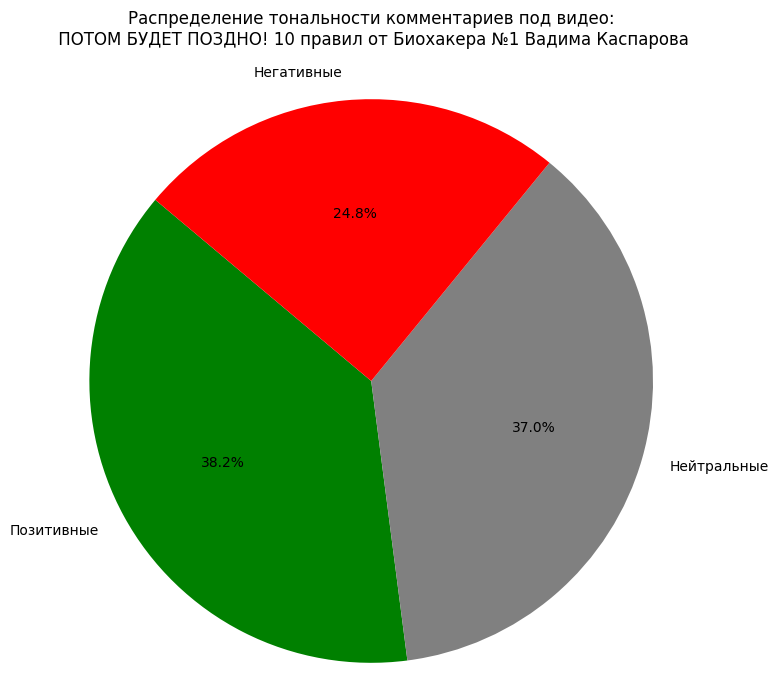

Примеры комментариев:

Позитивный комментарий:
Впервые увидел Глеба благодаря Маркаряну. Канал растет стремительно, и Глеб, на мой взгляд, гораздо лучше более известных интервьюеров. Искренность подкупает. Никакого чсв, как у более именитых. Ждем 1млн подписчиков. Спасибо за подкасты. От победы к победе🏆

Нейтральный комментарий:
Глеб миноксидилом балуется?

Негативный комментарий:
Каспаров уважаемый человек, но подкаст получился скучным, ибо говорили про какую-то банальщину, про которую уже все давным давно знают


In [77]:
if __name__ == '__main__':
    # Запрашиваем у пользователя ссылку на YouTube видео
    url = input("Введите ссылку на YouTube видео: ")
    video_id = extract_video_id(url)

    if not video_id:
        print("Не удалось извлечь video_id из ссылки. Проверьте корректность URL.")
    else:
        print("Извлеченный video_id:", video_id)
        video_title = get_video_title(video_id)
        print("Название видео:", video_title)
        all_comments = get_comments(video_id)
        print(f"Общее количество комментариев: {len(all_comments)}\n")

        # Анализ тональности каждого комментария с использованием модели для русского языка
        sentiment_results = analyze_sentiments(all_comments)

        # Агрегированный анализ: считаем количество комментариев по категориям
        pos_count = 0
        neu_count = 0
        neg_count = 0

        # Переменные для хранения примеров комментариев
        pos_comments = []
        neu_comments = []
        neg_comments = []


        for result in sentiment_results:
            label = result['label'].lower()
            if 'positive' in label or 'позитив' in label:
                pos_count += 1
                pos_comments.append(result['comment'])
            elif 'negative' in label or 'негатив' in label:
                neg_count += 1
                neg_comments.append(result['comment'])
            elif 'neutral' in label or 'нейтраль' in label:
                neu_count += 1
                neu_comments.append(result['comment'])

        total = pos_count + neu_count + neg_count
        print("Агрегированные данные по тональности:")
        print(f"Позитивных комментариев: {pos_count} ({pos_count / total * 100:.2f}%)")
        print(f"Нейтральных комментариев: {neu_count} ({neu_count / total * 100:.2f}%)")
        print(f"Негативных комментариев: {neg_count} ({neg_count / total * 100:.2f}%)\n")


        # Визуализация: Круговая диаграмма распределения тональности
        labels = ['Позитивные', 'Нейтральные', 'Негативные']
        sizes = [pos_count, neu_count, neg_count]
        colors = ['green', 'grey', 'red']

        plt.figure(figsize=(8, 8))
        plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
        plt.title(f'Распределение тональности комментариев под видео:\n {video_title}\n')
        plt.axis('equal')  # чтобы круговая диаграмма была круглой
        plt.show()

        # Вывод примеров комментариев для каждой категории
        pos_example = random.choice(pos_comments) if pos_comments else None
        neu_example = random.choice(neu_comments) if neu_comments else None
        neg_example = random.choice(neg_comments) if neg_comments else None

        print("Примеры комментариев:")
        if pos_example:
            print("\nПозитивный комментарий:")
            print(pos_example)
        else:
            print("\nПозитивных комментариев не найдено.")

        if neu_example:
            print("\nНейтральный комментарий:")
            print(neu_example)
        else:
            print("\nНейтральных комментариев не найдено.")

        if neg_example:
            print("\nНегативный комментарий:")
            print(neg_example)
        else:
            print("\nНегативных комментариев не найдено.")